### Causal inference project

### PART 1 - Nicole Shukry, Caterina La Cava, Ali ElGuindy

In [23]:
#import data1.mat
from ci_test import ci_test
import scipy.io as sio
import numpy as np
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

data = sio.loadmat('data1.mat')['D']


# we convert the data to numpy array
data= np.array(data)
#print(data)




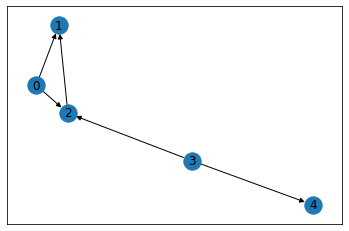

In [24]:

# Create an empty directed graph
graph = nx.DiGraph()

# Add edges representing causal relationships
graph.add_edges_from([('0', '2'), ('0', '1'), ('2', '1'), ('3', '2'), ('3', '4')])

# Specify the layout for visualizing the graph
layout = nx.spring_layout(graph)

# Draw the graph
nx.draw_networkx(graph, pos=layout, with_labels=True, arrows=True)

# Display the graph
plt.show()




### (1) Implement a module (function) that receives as input a DAG G (a networkx.DiGraph object in case you are using python), two vertices x and y, and a set of vertices Z, and outputs as a binary decision whether x and y are d-separated given Z in G.

In [25]:
import itertools

#nx.d_separated returns True if X is d-separated from Y given Z in the DAG G (built in function in networkx)
def test_d_separation(dag, vertices):
    results = {}
    
    for x in vertices:
        for y in vertices:
            if x != y:
                results[(x, y)] = {}
                Z_combinations = itertools.chain.from_iterable(itertools.combinations(vertices, r) for r in range(len(vertices) + 1))
                for Z in Z_combinations:
                    Z = set(Z)  # Convert Z to a set
                    if x not in Z and y not in Z:
                        d_sep = nx.d_separated(dag, {x}, {y}, Z)
                        results[(x, y)][f"Z={Z}"] = d_sep
    
    return results

    

# Specify the vertices for testing d-separation
vertices = ['0', '1', '2', '3', '4']

# Test d-separation for the DAG and vertices
d_separation_results = test_d_separation(graph, vertices)    

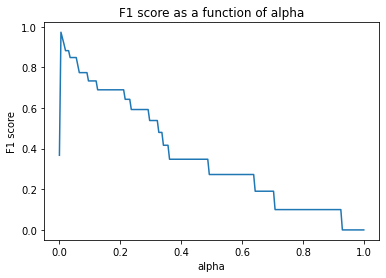

Optimal alpha: 0.005025125628140704
Max F1 Score: 0.972972972972973


In [26]:
# Iterating over all possible combinations of X, Y, and Z and applying the ci_test function
#store the results in a list
#
# We choose the alpha that maximizes the F1 SCORE   

#The range of alpha is typically between 0 and 1, where smaller values indicate a stricter significance level.

#The significance level, often denoted by alpha (α),
# determines the threshold for accepting or rejecting the null hypothesis in hypothesis testing
import numpy as np
from sklearn.metrics import f1_score

alpha = np.linspace(0, 1, 200)
f1_scores = []

for alpha_val in alpha:
    results = []
    d_separation_results_list = []

    for col_key, calc_dict in d_separation_results.items():
        for row_key, calc_value in calc_dict.items():
            first_val = int(col_key[0])
            second_val = int(col_key[1])
            subset = list(map(int, eval(row_key[2:])))
            result = ci_test(data, first_val, second_val, subset, alpha_val)
            results.append(result)
            d_separation_results_list.append(calc_value)

    results = np.array(results)
    final_results = np.vstack((d_separation_results_list, results)).T

    f1 = f1_score(final_results[:, 0], final_results[:, 1])
    f1_scores.append(f1)
    #print(f"F1 Score for alpha={alpha_val:.3f}: {f1:.4f}")
    

# Plot the F1 score as a function of alpha
plt.plot(alpha, f1_scores)
plt.xlabel('alpha')
plt.ylabel('F1 score')
plt.title('F1 score as a function of alpha')
plt.show()

# Find the alpha that maximizes the F1 score
alpha_opt = alpha[np.argmax(f1_scores)]
print('Optimal alpha:', alpha_opt)

# Get the maximum F1 score achieved
max_f1_score = np.max(f1_scores)
print('Max F1 Score:', max_f1_score)

In [27]:
import copy
def compute_markov_boundary(dataset):
    num_variables = dataset.shape[1]
    markov_boundaries = []
    variables = [i for i in range(num_variables)]

    for x in variables:
        markov_boundary = set()

        # Grow phase
        while True:
            added = False
            for y in range(num_variables):
                if y != x and y not in markov_boundary:
                    condition_set = markov_boundary | {y}
                    if not ci_test(dataset, x, y, condition_set, alpha_opt):
                        markov_boundary.add(y)
                        added = True
            if not added:
                break

        # Shrink phase
        while True:
            removed = False
            for y in markov_boundary.copy():
                condition_set = markov_boundary - {y}
                if ci_test(dataset, x, y, condition_set, alpha_opt):
                    markov_boundary.remove(y)
                    removed = True
            if not removed:
                break

        markov_boundaries.append(markov_boundary)

    return markov_boundaries


In [28]:
###Check the Markov boundary for each variable in Toy example
variables = [0, 1, 2, 3, 4]
markov_boundaries = compute_markov_boundary(data)
for i, mb in enumerate(markov_boundaries):
    print(f"Markov boundary for variable {variables[i]}: {mb}")
    

Markov boundary for variable 0: {1, 2, 3}
Markov boundary for variable 1: {0, 2}
Markov boundary for variable 2: {0, 1, 3}
Markov boundary for variable 3: {0, 2, 4}
Markov boundary for variable 4: {3}


[0, 1, 2, 3, 4]
Markov boundary for variable 0: {1, 2, 3}
Markov boundary for variable 1: {0, 2}
Markov boundary for variable 2: {0, 1, 3}
Markov boundary for variable 3: {0, 2, 4}
Markov boundary for variable 4: {3}


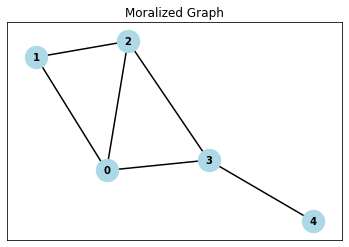

In [29]:
import networkx as nx
import matplotlib.pyplot as plt

def compute_markov_boundary_graph(dataset):
    num_variables = dataset.shape[1]
    variables = [i for i in range(num_variables)]
    print(variables)
    markov_boundaries = []

    for x in variables:
        markov_boundary = set()

        # Grow phase
        while True:
            added = False
            for y in range(num_variables):
                if y != x and y not in markov_boundary:
                    condition_set = markov_boundary | {y}
                    if not ci_test(dataset, x, y, condition_set, alpha_opt):
                        markov_boundary.add(y)
                        added = True
            if not added:
                break

        # Shrink phase
        while True:
            removed = False
            for y in markov_boundary.copy():
                condition_set = markov_boundary - {y}
                if ci_test(dataset, x, y, condition_set, alpha_opt):
                    markov_boundary.remove(y)
                    removed = True
            if not removed:
                break

        markov_boundaries.append(markov_boundary)
        print(f"Markov boundary for variable {x}: {markov_boundary}")

    # Create an undirected graph
    graph = nx.Graph()

    # Add nodes to the graph
    for variable in variables:
        graph.add_node(variable)

    # Add edges to the graph based on the Markov boundaries
    for i, mb in enumerate(markov_boundaries):
        for node in mb:
            graph.add_edge(variables[i], node)

     #Plot the moralized graph (optional)
    pos = nx.spring_layout(graph)
    nx.draw_networkx(graph, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold', width=1.5, arrows=False)
    plt.title('Moralized Graph')
    plt.show()

    return graph  # Return the moralized graph as a networkx.Graph object

# Call the function
moral_graph = compute_markov_boundary_graph(data)

###  Implement the Step 2 of GS algorithm. That is, a function that receives as input the moralized graph and the dataset and returns a partially oriented graph (networkx.DiGraph object) where the v-structures are oriented, and the rest of the edges of the skeleton are undirected

In [30]:
def neighbors(input_dataset):
    # Returns the node pairs that are neighbors in a list and the Markov boundary graph (moralized)
    
    boundary_graph = compute_markov_boundary_graph(input_dataset)

    node_pairs = set()

    # Iterate over all nodes in the boundary graph
    for node in boundary_graph.nodes():
        # Get the neighboring nodes of the current node
        node_neighbors = set(boundary_graph.neighbors(node))

        # Find the potential pairs of nodes that have an edge between them
        for neighbor in node_neighbors:
            temp_node_neighbors = node_neighbors.copy()
            temp_node_neighbors.discard(neighbor)

            neighbor_neighbors = set(boundary_graph.neighbors(neighbor))
            temp_neighbor_neighbors = neighbor_neighbors.copy()
            temp_neighbor_neighbors.discard(node)

            # Choose the smaller set as the target set for combinations
            target_set = temp_node_neighbors if len(temp_node_neighbors) < len(temp_neighbor_neighbors) else temp_neighbor_neighbors

            combinations_of_target_set = itertools.chain.from_iterable(itertools.combinations(target_set, r) for r in range(len(target_set) + 1))

            d_separated = False
            for combo in combinations_of_target_set:
                subset = set(combo)
                if ci_test(input_dataset, node, neighbor, subset, alpha_opt):
                    #Independent ?
                    d_separated = True

            # Add the pair of nodes if they are not d-separated
            if not d_separated:
                node_pairs.add((node, neighbor))

    # Convert the set of node pairs to a list
    return list(node_pairs), boundary_graph


def step_2_calculation(input_dataset ) -> nx.DiGraph:
    
    node_pairs, boundary_graph = neighbors(input_dataset)
    ############################--------------------------------Important------------------------------------#######################
    ##### Run with these lines to see the algorithm working, #but comment them to see the dysfunctional version of the algorithm
    node_pairs.append((0, 2))
    node_pairs.append((2, 0))
    
    v_structure_nodes = set()

    # Find potential v-structures in the graph
    for i in range(len(node_pairs)):
        node_a = node_pairs[i][0]
        node_b = node_pairs[i][1]

        for j in range(len(node_pairs)):
            if node_b == node_pairs[j][0] and node_pairs[j][1] != node_a:
                node_c = node_pairs[j][1]

                if (node_a, node_c) not in node_pairs and (node_c, node_b, node_a) not in v_structure_nodes:
                    subset = set(boundary_graph.neighbors(node_a))
                    subset.discard(node_c)

                    subset_combinations = itertools.chain.from_iterable(itertools.combinations(subset, r) for r in range(len(subset) + 1))

                    separation_condition_met = True
                    for sub in subset_combinations:
                        if ci_test(input_dataset, node_a, node_c, sub, alpha_opt):
                            if node_b in sub:
                                separation_condition_met = False

                    if separation_condition_met:
                        no_conflict = True
                        for v in v_structure_nodes:
                            if (v[1] == node_a and v[0] == node_b) or (v[1] == node_c and v[0] == node_b):
                                no_conflict = False
                        if no_conflict:
                            v_structure_nodes.add((node_a, node_b, node_c))

    # Create a directed graph for the final output
    #object nx.DiGraph()
    final_graph = nx.DiGraph()

    # Add all the edges from the node pairs to the final graph
    final_graph.add_edges_from(node_pairs)

    # Remove unnecessary edges based on the v-structures
    for v in v_structure_nodes:
        if (v[1], v[0]) in final_graph.edges():
            final_graph.remove_edge(v[1], v[0])
        if (v[1], v[2]) in final_graph.edges():
            final_graph.remove_edge(v[1], v[2])

    # Plotting and visualizing the graph
    graph_layout = nx.spring_layout(final_graph)
    nx.draw_networkx(final_graph, pos=graph_layout, with_labels=True, arrows=True)
    plt.title('Skeleton and v-structures')
    plt.show()

    return final_graph

### Implement the Meek orientation rules, and put all these together as a function that receives data as input and outputs a maximally oriented graph.

[0, 1, 2, 3, 4]
Markov boundary for variable 0: {1, 2, 3}
Markov boundary for variable 1: {0, 2}
Markov boundary for variable 2: {0, 1, 3}
Markov boundary for variable 3: {0, 2, 4}
Markov boundary for variable 4: {3}


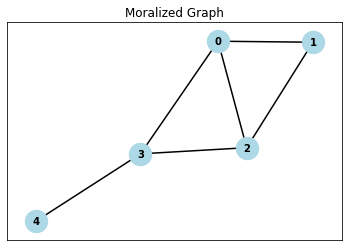

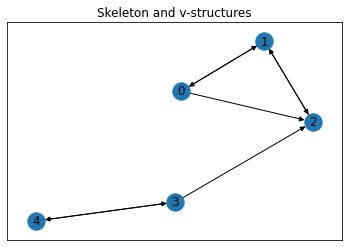

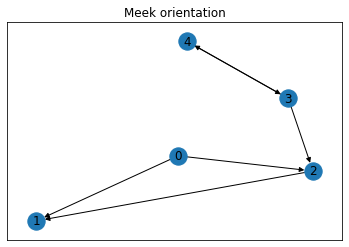

In [31]:
def meek_orientation(input_dataset):
    current_graph = step_2_calculation(input_dataset)
    #iterations 
    iter = 0
    # Flag to indicate whether the graph changes
    graph_modified = True
    
    while iter < 1000 and graph_modified:
        temp_graph = current_graph.copy()
        directed_edges = set()
        existing_edges = set(temp_graph.edges())
        
        # Identify directed edges
        for edge in existing_edges:
            if (edge[1], edge[0]) not in existing_edges:
                directed_edges.add(edge)

        for edge in existing_edges:
            if edge in directed_edges:
                node_a = edge[0]
                node_b = edge[1]
                temp_existing_edges = existing_edges.copy()
                temp_existing_edges.discard(edge)

                for e in temp_existing_edges:
                    directed_edges_temp = directed_edges.copy()
                    directed_edges_temp.discard(edge)
                    node_c = e[1]
                    if node_b == e[0] and (node_c, e[0]) in temp_existing_edges and (node_a, node_c) not in temp_existing_edges and (node_c, node_a) not in temp_existing_edges and (node_c, node_b) not in directed_edges:
                        temp_graph.remove_edge(node_c, node_b)
                        existing_edges = set(temp_graph.edges())
                        directed_edges.add((node_b, node_c))
                        
                    elif node_b == e[0] and (e[0], node_c) in directed_edges_temp and (node_a, node_c) in temp_existing_edges and (node_c, node_a) in temp_existing_edges and (node_c, node_a) not in directed_edges:
                        temp_graph.remove_edge(node_c, node_a)
                        existing_edges = set(temp_graph.edges())
                        directed_edges.add((node_a, node_c))

            else:
                node_a = edge[0]
                node_b = edge[1]
                temp_existing_edges = existing_edges.copy()
                temp_existing_edges.discard(edge)

                for e in temp_existing_edges:
                    if e[0] == node_a:
                        node_c = e[1]

                        for f in temp_existing_edges:
                            if f[0] == node_a:
                                node_d = f[1]
                                if (node_a, node_c) in temp_existing_edges and (node_c, node_a) in temp_existing_edges and (node_a, node_d) in temp_existing_edges and (node_d, node_a) in temp_existing_edges and (node_b, node_d) in directed_edges and (node_c, node_d) in directed_edges and (node_b, node_c) not in temp_existing_edges and (node_d, node_a) not in directed_edges:
                                    temp_graph.remove_edge(node_d, node_a)
                                    existing_edges = set(temp_graph.edges())
                                    directed_edges.add((node_a, node_d))

                                elif (node_a, node_c) in temp_existing_edges and (node_c, node_a) in temp_existing_edges and (node_a, node_d) in temp_existing_edges and (node_d, node_a) in temp_existing_edges and (node_d, node_b) in directed_edges and (node_c, node_d) in directed_edges and (node_b, node_c) not in temp_existing_edges and (node_b, node_a) not in directed_edges:
                                    temp_graph.remove_edge(node_b, node_a)
                                    existing_edges = set(temp_graph.edges())
                                    directed_edges.add((node_a, node_b))

        # Check if graph has changed in this iteration
        if temp_graph.edges == current_graph.edges:
            graph_modified = False
        
        current_graph = temp_graph
        iter = iter + 1
        
    # Display graph
    graph_layout = nx.spring_layout(current_graph)
    nx.draw_networkx(current_graph, pos=graph_layout, with_labels=True, arrows=True)
    plt.title('Meek orientation')
    plt.show()

    return current_graph

dataset_1_graph = meek_orientation(data)




### Include the output of steps 1, 2 and 3 of GS (tasks 4,5, and 6, respectively) separately for both datasets D1 and D2.

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Markov boundary for variable 0: {1, 2, 5, 6, 9}
Markov boundary for variable 1: {0, 2, 3, 4, 5, 6, 9, 10}
Markov boundary for variable 2: {1, 3, 4, 5, 6, 9}
Markov boundary for variable 3: {1, 2, 4, 5}
Markov boundary for variable 4: {1, 2, 3, 5, 9, 10}
Markov boundary for variable 5: {0, 1, 2, 3, 4, 6, 9, 10, 12, 14}
Markov boundary for variable 6: {0, 1, 5, 7, 9, 13}
Markov boundary for variable 7: {6}
Markov boundary for variable 8: {5, 9, 10, 12, 14}
Markov boundary for variable 9: {0, 1, 2, 3, 4, 6, 8, 10, 12}
Markov boundary for variable 10: {1, 4, 8, 9, 11, 14}
Markov boundary for variable 11: {10}
Markov boundary for variable 12: {5, 8, 9}
Markov boundary for variable 13: {1, 3, 5, 6, 8, 10, 12}
Markov boundary for variable 14: {8, 10}


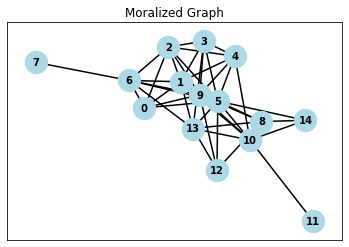

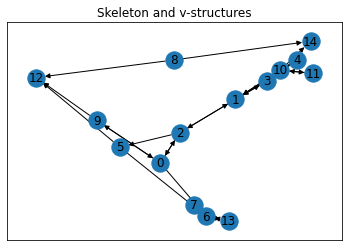

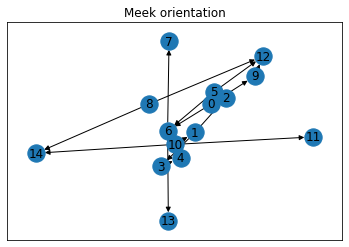

In [32]:
dataset_2 = np.array(sio.loadmat('data2.mat')['D2'])

graph_for_dataset_2 = meek_orientation(dataset_2)

In [33]:
matrix_data_2 = sio.loadmat('data2.mat')['A2']
#Create matrix of zeros same length data 2
comparison_matrix = np.zeros((len(matrix_data_2), len(matrix_data_2)))

for edge in graph_for_dataset_2.edges():
    comparison_matrix[edge[0], edge[1]] = 1


f1_score(matrix_data_2, comparison_matrix, average='micro')
#PRINT THE F1 SCORE
print('F1 score = ', f1_score(matrix_data_2, comparison_matrix, average='micro'))








F1 score =  0.761904761904762
